In [1]:
PROCESSED_PATH = '../data/processed/1_preprocessed.pkl'
FEATURE_SKILL_PATH = '../data/processed/features_skills_clusters.pkl'

target_col= ['DevType']
influnce_col = ['LanguageWorkedWith',
                  'DatabaseWorkedWith',
                  'WebframeWorkedWith',
                  'MiscTechWorkedWith',]

EXPORT_PATH    = "../data/processed/2_cleaned_data.pkl"

MLFLOW_TRACKING_URI = '../models/mlruns'
MLFLOW_EXPERIMENT_NAME = "skills_jobs_stackoverflow"


In [2]:
import pandas as pd 
import numpy as np
import logging
import pickle
import os
import seaborn as sns
import plotly 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
from pathlib import Path

from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import mlflow
from mlflow.tracking import MlflowClient
from sklearn.multioutput import MultiOutputClassifier



In [3]:
df = pd.read_pickle(EXPORT_PATH)

In [4]:
def generate_role_resample(role):
    df_role = df[df[('DevType',role)] == 1]
    df_notRole = df[df[('DevType',role)] == 0]
    if len(df_role) < len(df_notRole):
        n_samples = len(df_role)
    df_role = df_role.sample(n=n_samples, random_state=42)
    df_notRole = df_notRole.sample(n=n_samples, random_state=42)
    
    df_resample = pd.concat([df_role, df_notRole],axis=0)
    
    return df_resample

In [5]:
generate_role_resample('Data scientist or machine learning specialist')

skills_clusters                                               
        skill_group_0 skill_group_1 skill_group_10 skill_group_11   
53392               1             0              1              0  \
51623               1             0              1              0   
4343                0             0              0              1   
42367               1             0              2              0   
4450                2             0              2              0   
...               ...           ...            ...            ...   
43854               2             0              1              0   
4553                1             0              0              0   
19762               0             0              2              2   
34460               1             0              1              0   
16202               0             0              0              0   

                                                                               
      skill_group_12 skill_group_2 skill_group_3 skill_group_4 skill_group_5   
53392              1             0             0             3             0  \
51623              0             0             0             2             0   
4343               0             0             0             1             0   
42367              0             0             0             1             0   
4450               2             0             1             2             0   
...              ...           ...           ...           ...           ...   
43854              2             0             0             0             0   
4553               2             1             0             2             0   
19762              0             0             0             1             0   
34460              1             0             0             2             0   
16202              1             0             0             0             0   

                     ... MiscTechWorkedWith                              
      skill_group_6  ...            Node.js Pandas Puppet React Native   
53392             1  ...                  0      1      0            0  \
51623             1  ...                  0      1      0            0   
4343              1  ...                  0      0      0            0   
42367             0  ...                  0      1      0            0   
4450              1  ...                  0      0      0            0   
...             ...  ...                ...    ...    ...          ...   
43854             0  ...                  1      0      0            0   
4553              0  ...                  1      0      0            0   
19762             2  ...                  0      0      0            0   
34460             0  ...                  0      0      0            0   
16202             0  ...                  0      0      0            0   

                                                                        
      TensorFlow Teraform Torch/PyTorch Unity 3D Unreal Engine Xamarin  
53392          1        0             0        0             0       0  
51623          0        0             0        0             0       0  
4343           0        0             1        0             0       0  
42367          1        0             0        0             0       0  
4450           0        0             0        0             0       0  
...          ...      ...           ...      ...           ...     ...  
43854          0        0             0        0             0       0  
4553           1        0             0        0             0       0  
19762          0        0             0        0             0       0  
34460          0        0             0        0             0       0  
16202          0        0             0        0             0       0  

[1598 rows x 103 columns]

In [6]:
roles= df['DevType'].columns.to_list()
models={}
from sklearn.linear_model import LogisticRegression
for role in roles:
    bin_role = df['DevType'][role]
    df_resample = generate_role_resample(role)
    X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)
    
    clf= DecisionTreeClassifier(random_state=42, max_depth=3)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    per = precision_score(y_test, pred)
    recal = recall_score(y_test, pred)
    acc_test = f1_score(y_test, pred)
    
    models[role]= {'acc':acc, 'percesion':per,'recal':recal ,'F1':acc_test}
    
    
pd.DataFrame(models).T
    


C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\3260569021.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)
C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\3260569021.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)
C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\3260569021.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_

,acc,percesion,recal,F1
Academic researcher,0.733906,0.758929,0.708333,0.732759
Data or business analyst,0.761194,0.825688,0.666667,0.737705
Data scientist or machine learning specialist,0.893750,0.912500,0.879518,0.895706
Database administrator,0.689076,0.716667,0.682540,0.699187
DevOps specialist,0.745387,0.750000,0.776224,0.762887
"Developer, QA or test",0.515152,0.513514,0.575758,0.542857
"Developer, back-end",0.643960,0.604128,0.864816,0.711340
"Developer, desktop or enterprise applications",0.671151,0.741007,0.581921,0.651899
"Developer, embedded applications or devices",0.830189,0.865854,0.816092,0.840237
"Developer, front-end",0.727509,0.712242,0.769759,0.739884


C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


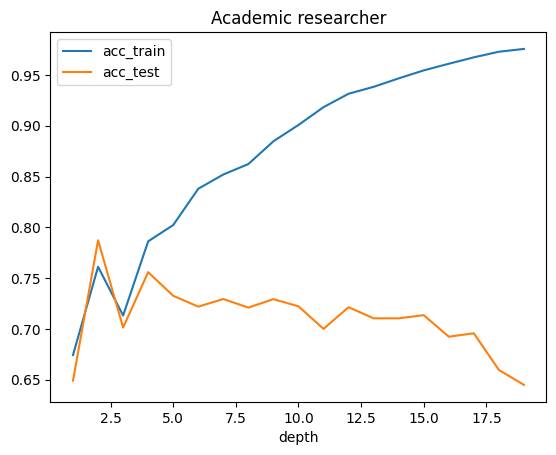

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


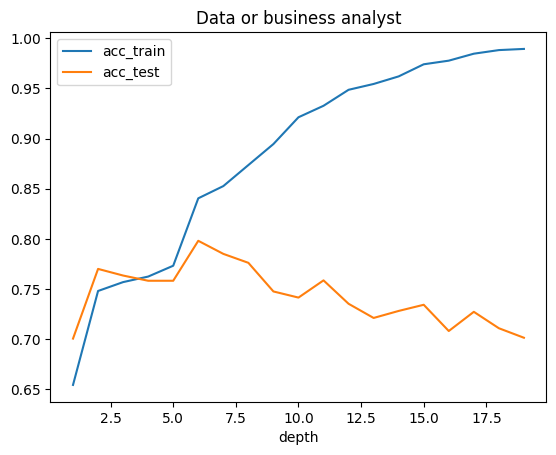

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


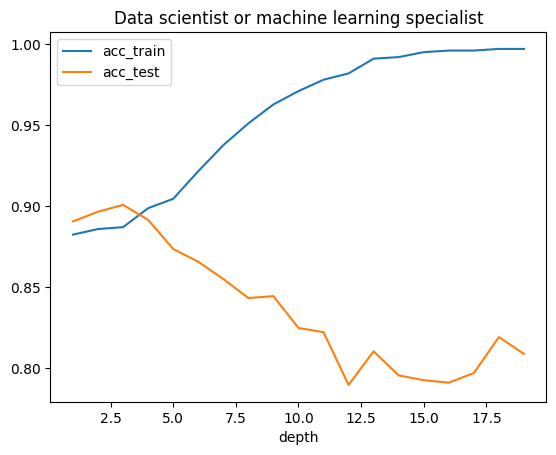

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


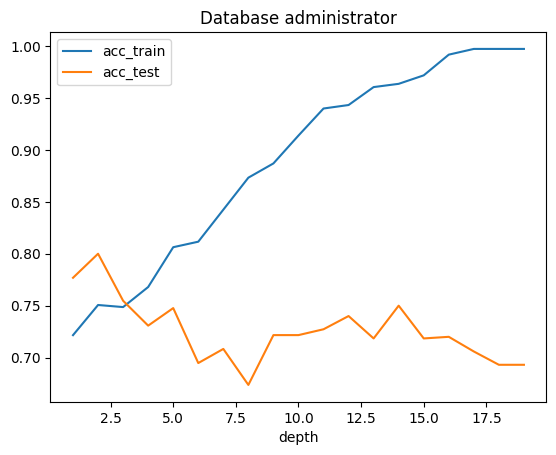

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


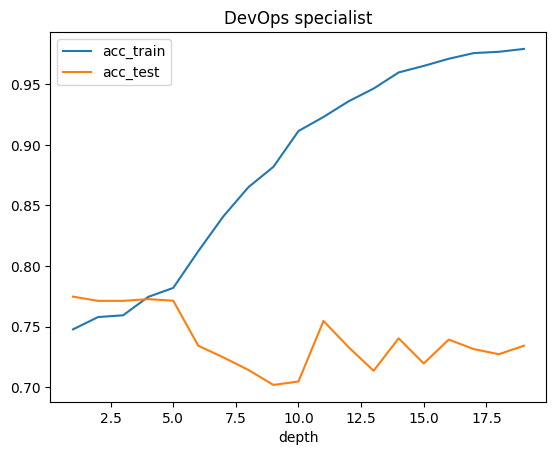

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


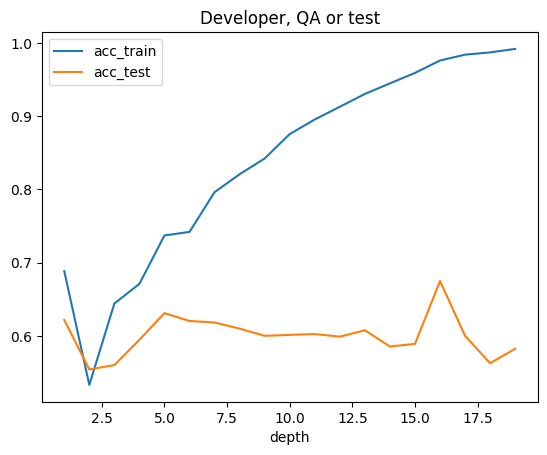

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


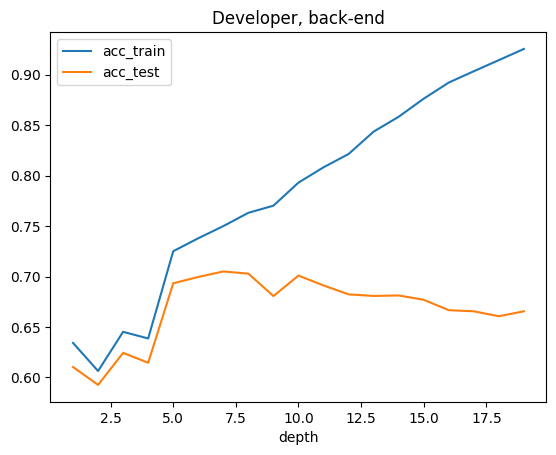

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


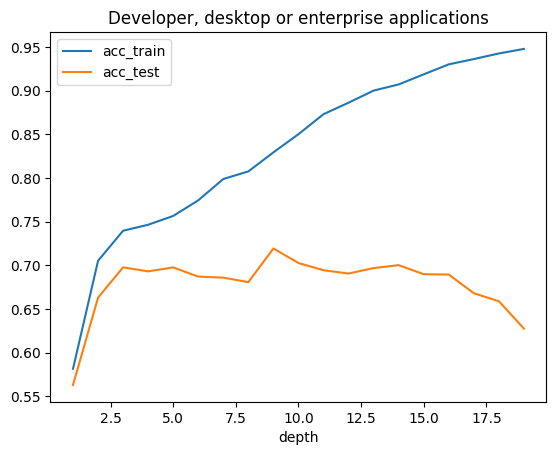

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


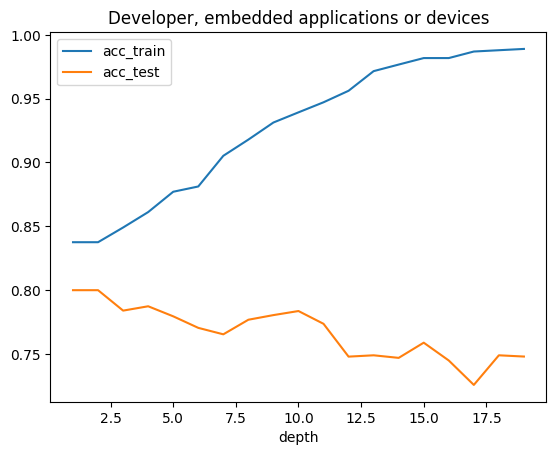

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


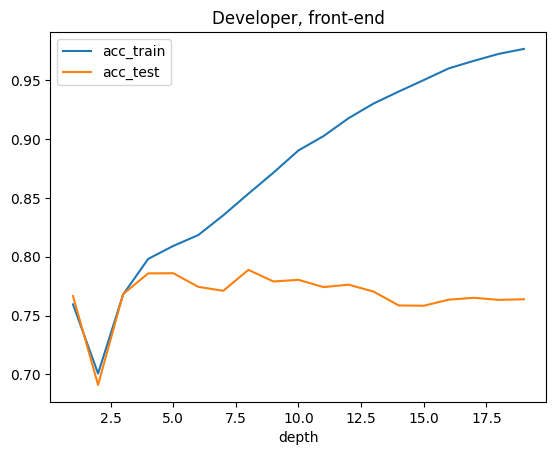

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


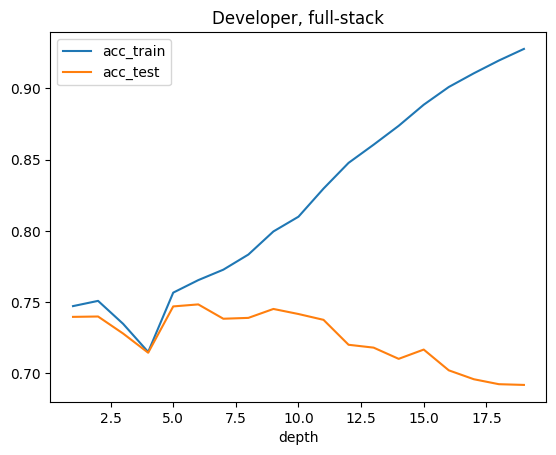

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


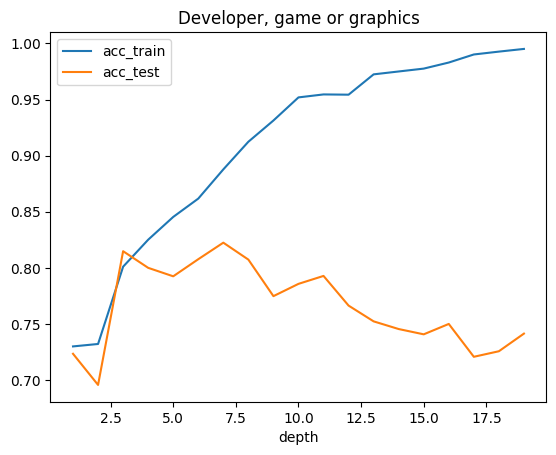

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


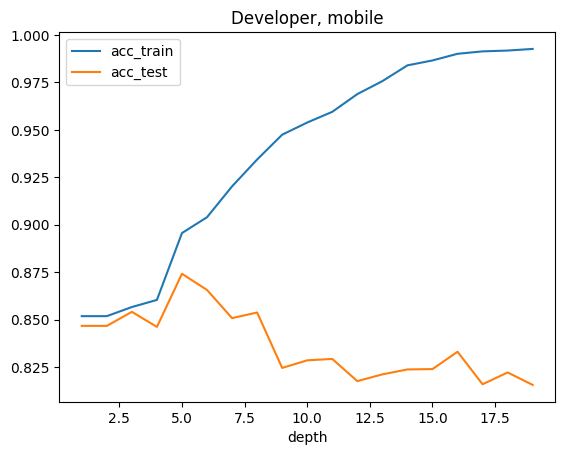

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


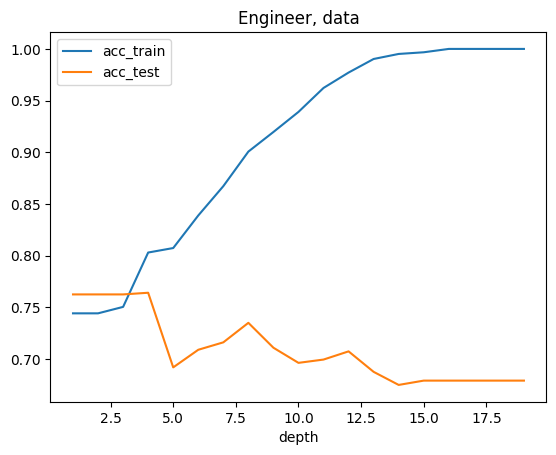

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


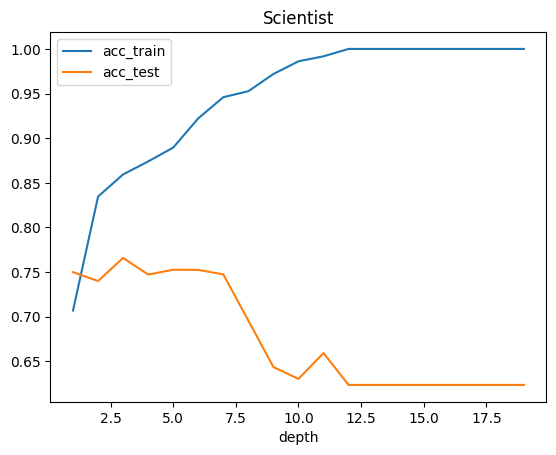

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\4159335014.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)


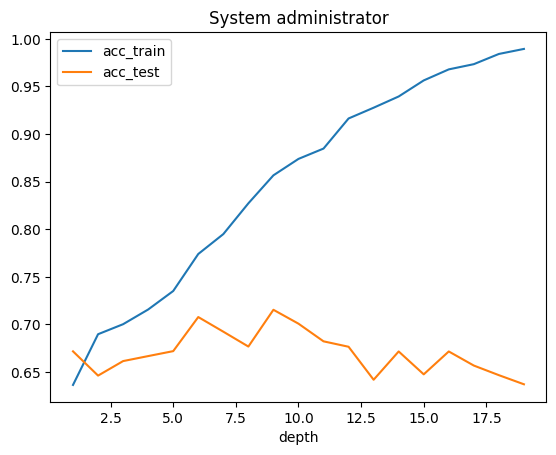

In [7]:
roles= df['DevType'].columns.to_list()

for role in roles:
    htp =[]

    df_resample = generate_role_resample(role)
    X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)
    X_train , X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    for depth in list(range(1,20)):
        
        clf= DecisionTreeClassifier(random_state=42, max_depth=depth)
        clf.fit(X_train, y_train)
        
        acc_test = f1_score(y_val,clf.predict(X_val))    
        acc_train = f1_score(y_train, clf.predict(X_train))
        
            
        htp.append([depth,acc_train, acc_test])
    
    htp = pd.DataFrame(htp, columns=['depth','acc_train','acc_test']).set_index('depth')
    htp.plot(title=role)
    plt.show()

In [8]:
roles= df['DevType'].columns.to_list()
models={}
f_imp={}
for role in roles:
    
    df_resample = generate_role_resample(role)
    X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)
    
    clf= DecisionTreeClassifier(random_state=42, max_depth=5)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    acc_train = f1_score(y_train, clf.predict(X_train))
    acc_test = f1_score(y_test, pred)
    
    f_imp[role] = pd.DataFrame({'feature':X_train.columns, 'importance':clf.feature_importances_}).sort_values(by='importance', ascending=False)
    
print(f_imp)
    


C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\3120125512.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)
C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\3120125512.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)
C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\3120125512.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_

{'Academic researcher':            feature  importance
11   skill_group_8    0.559498
3   skill_group_11    0.154104
54         Angular    0.049640
1    skill_group_1    0.030117
2   skill_group_10    0.027541
..             ...         ...
34           Scala    0.000000
33             SQL    0.000000
32            Rust    0.000000
31            Ruby    0.000000
86         Xamarin    0.000000

[87 rows x 2 columns], 'Data or business analyst':            feature  importance
11   skill_group_8    0.441098
37             VBA    0.197627
2   skill_group_10    0.143273
6    skill_group_3    0.027635
0    skill_group_0    0.024062
..             ...         ...
36      TypeScript    0.000000
35           Swift    0.000000
34           Scala    0.000000
33             SQL    0.000000
86         Xamarin    0.000000

[87 rows x 2 columns], 'Data scientist or machine learning specialist':           feature  importance
11  skill_group_8    0.852503
29         Python    0.028298
21        Haskell

C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\3120125512.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)
C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\3120125512.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_resample['DevType'][role], test_size=0.2, random_state=42)
C:\Users\Sameh\AppData\Local\Temp\ipykernel_21604\3120125512.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train , X_test, y_train, y_test = train_test_split(df_resample.drop(columns=['DevType']).droplevel(0,axis=1), df_